# LOW-RANK PARAREAL NOTEBOOK

**Author:** Benjamin Carrel (University of Geneva)

This notebook aims to verify the numerical behavior of the low-rank Parareal algorithm.

## Package importations

Usual python importation of packages. Run it first.

In [1]:
## IMPORTATIONS
import numpy as np
from matplotlib import pyplot as plt, cm
from IPython.display import HTML
import os

from ivps import riccati
import classical_solvers
from pint import parareal


## Parameters for the experiments

In the following cell:
- Choose if you want to save the figures.
- Choose if you want to plot animations.
- Choose the method for the reference solution (optimal will automatically use the closed form formula or scipy).

The rest of the notebook can be ran without edition.


In [2]:
## Do save the figures, or do not.
do_save_figs = True # defaults to True

## Do plot the animations, or do not.
do_plot_anims = True

## Numerical method used to compute the reference solution
classic_meth = 'optimal' # defaults to 'optimal'



## Creation of the problem

Start here by defining the problem to solve.

In [3]:
# RICCATI PROBLEM
PB_name = 'Riccati_oste'
## Problem parameters
t_span=(0.01, 0.11)
m = 200 # defaults to 200
q = 9 # defaults to 9
PB = riccati.make_riccati_ostermann(t_span, m, q, initial_rank=20)
## Parareal parameters
nb_parareal_iter = 20
is_parallel = True
## Coarse solver related parameters
coarse_rank = 6
coarse_dlra_meth = 'KSL2' # defaults to 'KSL2'
nb_coarse_substeps = 10 # defaults to 10
several_coarse_ranks = (4, 6, 8)
## Fine solver related parameters
fine_rank = 18
fine_dlra_meth = 'KSL2' # defaults to 'KSL2'
nb_fine_substeps = 200 # defaults to 200
several_fine_ranks = (14, 18, 22)

    

In [4]:
# EXTRACT VARIABLES
iv = PB.Y0
min_shape = min(PB.Y_shape)

# PATH FOR FIGURES
current_dir = os.path.curdir
figures_dir = os.path.join(current_dir, f'figures/{PB_name}/size{min_shape}/')
if not os.path.isdir(figures_dir):
    os.makedirs(figures_dir)

## Reference solution and singular values

In this section, we compute the reference solution and check the singular values.

In [5]:
reference_solution = classical_solvers.solve(PB, t_span, iv, method=classic_meth, nb_t_steps=nb_parareal_iter, monitoring=True)
reference_solution.convert_to_dense()
print(reference_solution)

Solving with optimal:   0%|          | 0/20 [00:00<?, ?it/s]/Users/benjamin/Documents/GitHub/Low-rank-Parareal/src/classical_methods.py:24: UserWarning: Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix
  warnings.warn('Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix')
Solving with optimal: 100%|██████████| 20/20 [16:51<00:00, 50.59s/it]

Problem: Riccati of shape (200, 200)
Number of time steps: 21 
Stepsize: h=0.004999999999999999 
Total time of computation: 1011.86 seconds


In [6]:
anim_sing_vals = reference_solution.animation_singular_values(figures_dir + f'anim_singular_values_stagnation1.gif', do_save=do_save_figs)
if do_plot_anims:
    do_anim = HTML(anim_sing_vals.to_jshtml())
else:
    do_anim = None
do_anim

MovieWriter ffmpeg unavailable; using Pillow instead.


## LOW-RANK PARAREAL


In [7]:
### CREATE A LOW-RANK PARAREAL OBJECT
LRP = parareal.LowRankParareal(problem = PB,
                               coarse_rank=coarse_rank,
                               fine_rank=fine_rank,
                               nb_parareal_iter=nb_parareal_iter,
                               nb_coarse_substeps=nb_coarse_substeps,
                               coarse_dlra_method=coarse_dlra_meth,
                               nb_fine_substeps=nb_fine_substeps,
                               fine_dlra_method=fine_dlra_meth,
                               reference_solution=reference_solution)
LRP

Low-rank Parareal method with following properties: 
Problem: Riccati of shape (200, 200) 
Coarse solver: KSL2 with 10 substep(s) 
Fine solver: KSL2 with 200 substep(s) 
Number of parareal iterations: 20

### The coarse and the fine solvers

First of all, we check the error made by the coarse and fine solvers. 

The integrators must have converged to the DLRA solution for meaningful results.

DLRA (rank 18): 100%|██████████| 20/20 [05:16<00:00, 15.81s/it]


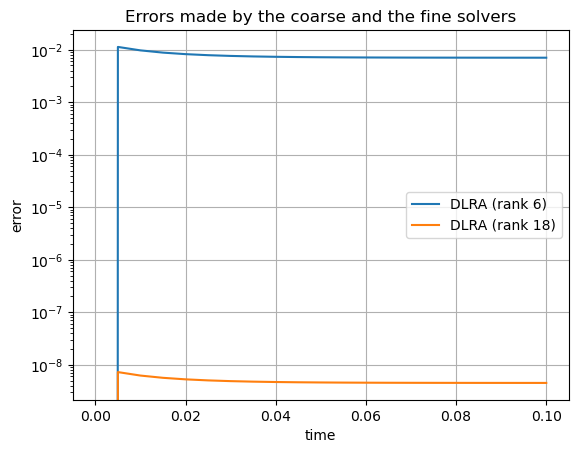

In [8]:
## COARSE SOLUTION
LRP.compute_coarse_solution()

## FINE SOLUTION
LRP.compute_fine_solution()

## PLOT THE ERRORS
fig1 = LRP.plot_coarse_and_fine_errors(title='Errors made by the coarse and the fine solvers', 
                                       do_save=do_save_figs, 
                                       filename=figures_dir + f'DLRA_errors_over_time.pdf')


### Low-rank Parareal algorithm

In this section, we inspect the behavior of the algorithm by plotting the error at each iteration.

/!\ THE COMPUTATIONS MAY TAKE A MOMENT /!\

In [9]:
## LOW-RANK PARAREAL ALGORITHM
Ynk = LRP.compute_parareal(skip_confirmation=True, do_parallel=is_parallel)

Solving with optimal:   0%|          | 0/20 [00:00<?, ?it/s]/Users/benjamincarrel/Documents/UNIGE/PhD/Code/research/src/classical_methods.py:24: UserWarning: Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix
  warnings.warn('Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix')
Solving with optimal: 100%|██████████| 20/20 [03:02<00:00,  9.14s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 6).
The fine solver is DLRA (rank 18).
The total time of computation is estimated at 672 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [04:37<00:00, 13.88s/it]

Done. Total time of computation: 289 seconds.


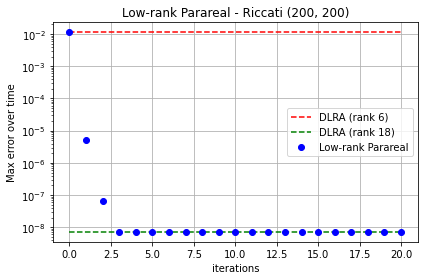

In [10]:
## LOW-RANK PARAREAL ANIMATION
LRP_animation = LRP.animation_parareal(title='Low-rank Parareal',
                                       do_save=do_save_figs,
                                       filename=figures_dir + f'anim_parareal_stagnation1_q_{coarse_rank}_r_{fine_rank}.gif')
if do_plot_anims:
    plot_anim = HTML(LRP_animation.to_jshtml())
else:
    plot_anim = None
plot_anim

### Several coarse ranks

We look at the behavior of the algorithm with several coarse ranks.

In [11]:
# SEVERAL COARSE RANKS
it = np.arange(0, nb_parareal_iter+1)
err_para_coarse_ranks = np.zeros((nb_parareal_iter+1, len(several_coarse_ranks)))

for k in range(len(several_coarse_ranks)):
    LRP.coarse_rank = several_coarse_ranks[k]
    LRP.fine_rank = fine_rank
    Ynk = LRP.compute_parareal(skip_confirmation=True, do_parallel=is_parallel)
    Enk = LRP.compute_parareal_error()
    err_para_coarse_ranks[:, k] = np.max(Enk, axis=0)

Solving with optimal:   0%|          | 0/20 [00:00<?, ?it/s]/Users/benjamincarrel/Documents/UNIGE/PhD/Code/research/src/classical_methods.py:24: UserWarning: Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix
  warnings.warn('Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix')
Solving with optimal: 100%|██████████| 20/20 [02:28<00:00,  7.42s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 4).
The fine solver is DLRA (rank 18).
The total time of computation is estimated at 659 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [04:14<00:00, 12.70s/it]


Done. Total time of computation: 262 seconds.


Solving with optimal: 100%|██████████| 20/20 [04:35<00:00, 13.77s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 6).
The fine solver is DLRA (rank 18).
The total time of computation is estimated at 658 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [2:50:39<00:00, 511.96s/it]  


Done. Total time of computation: 10250 seconds.


Solving with optimal: 100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 8).
The fine solver is DLRA (rank 18).
The total time of computation is estimated at 687 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [04:45<00:00, 14.30s/it]

Done. Total time of computation: 298 seconds.


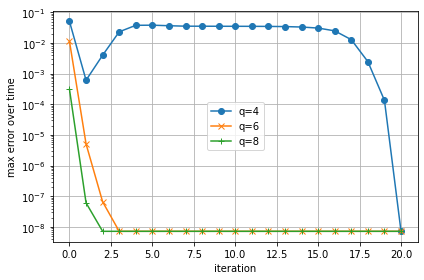

In [12]:
# PLOT SEVERAL COARSE RANKS
linestyles = ('-o', '-x', '-+')
fig = plt.figure(clear=True)
for k in range(len(several_coarse_ranks)):
    plt.semilogy(it, err_para_coarse_ranks[:, k], linestyles[k], label=f'q={several_coarse_ranks[k]}')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.legend()
plt.show()
if do_save_figs:
    fig.savefig(figures_dir + f'several_coarse_ranks_{several_coarse_ranks}.pdf')

### Several fine ranks

We look at the behavior of the algorithm with several fine ranks.

In [13]:
# SEVERAL FINE RANKS
it = np.arange(0, nb_parareal_iter+1)
err_para_fine_ranks = np.zeros((nb_parareal_iter+1, len(several_fine_ranks)))

for k in range(len(several_fine_ranks)):
    LRP.coarse_rank = coarse_rank
    LRP.fine_rank = several_fine_ranks[k]
    Ynk = LRP.compute_parareal(skip_confirmation=True, do_parallel=is_parallel)
    Enk = LRP.compute_parareal_error()
    err_para_fine_ranks[:, k] = np.max(Enk, axis=0)



Solving with optimal:   0%|          | 0/20 [00:00<?, ?it/s]/Users/benjamincarrel/Documents/UNIGE/PhD/Code/research/src/classical_methods.py:24: UserWarning: Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix
  warnings.warn('Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix')
Solving with optimal: 100%|██████████| 20/20 [02:32<00:00,  7.63s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 6).
The fine solver is DLRA (rank 14).
The total time of computation is estimated at 428 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [03:51<00:00, 11.60s/it]


Done. Total time of computation: 243 seconds.


Solving with optimal: 100%|██████████| 20/20 [02:30<00:00,  7.51s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 6).
The fine solver is DLRA (rank 18).
The total time of computation is estimated at 659 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [04:40<00:00, 14.05s/it]


Done. Total time of computation: 292 seconds.


Solving with optimal: 100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 6).
The fine solver is DLRA (rank 22).
The total time of computation is estimated at 948 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [06:06<00:00, 18.32s/it]

Done. Total time of computation: 378 seconds.


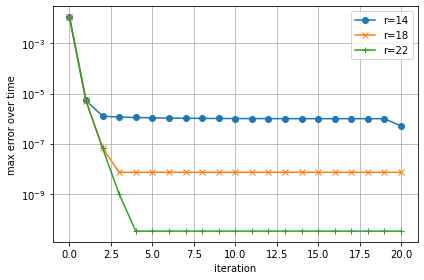

In [14]:
# PLOT SEVERAL FINE RANKS
linestyles = ('-o', '-x', '-+')
fig = plt.figure(clear=True)
for k in range(len(several_fine_ranks)):
    plt.semilogy(it, err_para_fine_ranks[:, k], linestyles[k], label=f'r={several_fine_ranks[k]}')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.legend()
plt.show()
if do_save_figs:
    fig.savefig(figures_dir + f'several_fine_ranks_{several_fine_ranks}.pdf')

### Several final times

In this section, we study the behavior of the algorithm with several final times of the problem.

In [15]:
# SEVERAL FINAL TIMES
several_final_times = (0.1, 0.5, 1.0)
err_several_final_times = np.zeros((nb_parareal_iter+1, len(several_final_times)))

for k in range(len(several_final_times)):
    # EDIT THE PROBLEM
    print(f'Time interval length: {several_final_times[k]}')
    new_t_span = (t_span[0], t_span[0] + several_final_times[k])
    LRP.problem = riccati.make_riccati_ostermann(new_t_span, m, q)

    # COMPUTE LOW-RANK PARAREAL
    LRP.coarse_rank = coarse_rank
    LRP.fine_rank = fine_rank
    Ynk = LRP.compute_parareal(skip_confirmation=True, do_parallel=is_parallel)
    Enk = LRP.compute_parareal_error()
    err_several_final_times[:, k] = np.max(Enk, axis=0)

Time interval length: 0.1


Solving with optimal:   0%|          | 0/20 [00:00<?, ?it/s]/Users/benjamincarrel/Documents/UNIGE/PhD/Code/research/src/classical_methods.py:24: UserWarning: Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix
  warnings.warn('Efficiency issue: tried to use scipy with a low-rank matrix -> converted to dense matrix')
Solving with optimal: 100%|██████████| 20/20 [02:49<00:00,  8.47s/it]


Please check the parameters:
The problem to solve is Riccati of shape (200, 200).
The coarse solver is DLRA (rank 6).
The fine solver is DLRA (rank 18).
The total time of computation is estimated at 662 seconds.
Started Parareal computations.


Low-rank Parareal applied to Riccati (200, 200): 100%|██████████| 20/20 [04:45<00:00, 14.26s/it]


Done. Total time of computation: 296 seconds.
Time interval length: 0.5


Solving with optimal:  30%|███       | 6/20 [04:14<10:11, 43.70s/it]

: 

: 

In [ ]:
# PLOT SEVERAL FINAL TIMES
it = np.arange(0, nb_parareal_iter+1)
fig = plt.figure(clear=True)
linestyles = ('o-','x-','+-')
for k in range(len(several_final_times)):
    stepsize = several_final_times[k] / nb_parareal_iter
    plt.semilogy(it, err_several_final_times[:, k], linestyles[k], label=f'h = {round(stepsize, 2)}')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.xlim((0,nb_parareal_iter+1))
plt.legend()
plt.show()
if do_save_figs:
    fig.savefig(figures_dir + f'several_final_times_{several_final_times}.pdf')

## ADAPTIVE LOW-RANK PARAREAL

In this section, we look at different aspects of an adaptive version of the low-rank Parareal algorithm

### Fixed coarse rank, adaptive fine rank

In [ ]:
## CREATE AN ADAPTIVE LOW-RANK PARAREAL OBJECT
ALRP = parareal.AdaptiveLowRankParareal(problem = PB,
                               coarse_rank=coarse_rank,
                               fine_tolerance=1e-8,
                               nb_parareal_iter=nb_parareal_iter,
                               nb_coarse_substeps=nb_coarse_substeps,
                               coarse_dlra_method=coarse_dlra_meth,
                               nb_fine_substeps=nb_fine_substeps,
                               fine_dlra_method=fine_dlra_meth,
                               reference_solution=reference_solution)

In [ ]:
## PLOT COARSE AND FINE ERRORS
fig = ALRP.plot_coarse_and_fine_errors('Errors made the coarse and the fine solvers', 
                                 do_save=do_save_figs,
                                 filename=figures_dir + f'adaptive1_DLRA_errors_over_time.pdf')

In [ ]:
## COMPUTE ADAPTIVE LOW-RANK PARAREAL...
Ynk = ALRP.compute_parareal(skip_confirmation=True, do_parallel=is_parallel)

In [ ]:
## ... AND ITS ANIMATION
ALRP_animation = ALRP.animation_parareal(title='Adaptive low-rank Parareal',
                                       do_save=do_save_figs,
                                       filename=figures_dir + f'anim_adaptive_parareal_q_{coarse_rank}_rtol_{ALRP.fine_tol}.gif')
if do_plot_anims:
    plot_anim = HTML(ALRP_animation.to_jshtml())
else:
    plot_anim = None
plot_anim

In [ ]:
## HEAT MAP OF THE RANK FOR N AND K
ranks_nk = np.zeros((nb_parareal_iter+1, nb_parareal_iter+1))
for n in np.arange(nb_parareal_iter+1):
    for k in np.arange(nb_parareal_iter+1):
        ranks_nk[n, k] = ALRP.parareal_solution[n, k].rank
        
        

fig = plt.figure()
plt.imshow(ranks_nk, cmap=cm.coolwarm, origin='lower')
plt.xlabel(r'iteration $k$')
plt.ylabel(r'time index $n$')
plt.colorbar()
plt.show()
if do_save_figs:
    fig.savefig(figures_dir + 'adaptive_parareal_ranks_map.pdf')


### Several fine tolerances

In [ ]:
# SEVERAL FINE TOLERANCES (ONLY LYAPUNOV)
several_fine_tols = [1e-6, 1e-8, 1e-10]

it = np.arange(0, nb_parareal_iter+1)
err_several_fine_tols = np.zeros((nb_parareal_iter+1, len(several_fine_tols)))

for k in range(len(several_fine_tols)):
    # LOW-RANK PARAREAL OF MODIFIED COARSE RANK
    ALRP.coarse_rank = coarse_rank
    ALRP.fine_tol = several_fine_tols[k]
    Ynk = ALRP.compute_parareal(skip_confirmation=True, do_parallel=is_parallel)
    Enk = ALRP.compute_parareal_error()
    err_several_fine_tols[:, k] = np.max(Enk, axis=0)

In [ ]:
# PLOT SEVERAL FINE TOLERANCES
fig = plt.figure(clear=True)
for k in range(len(several_fine_tols)):
    plt.semilogy(it, err_several_fine_tols[:, k], linestyles[k], label=f'tol={several_fine_tols[k]}')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.legend()
plt.show()
if do_save_figs:
    fig.savefig(figures_dir + f'several_fine_tols_{several_fine_tols}.pdf')

## END OF THE NOTEBOOK